# Problem 8.3
**Attributions**: Shashank, last paragraph discussions with Elena.

In Problem 8.3, we will be looking at data from parker et. al. to segment images using a constitutively expressed RFP. But first, let's import the required modules.|

In [24]:
import warnings

# Workhorse
import numpy as np
import pandas as pd

# A whole bunch of skimage stuff
import skimage.feature
import skimage.filter
import skimage.filter.rank
import skimage.io
import skimage.morphology
import skimage.restoration
import skimage.segmentation
import skimage.transform

# And some useful scipy.ndimage stuff
import scipy.ndimage

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must 
# come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots 
# (non-Bokeh)) SVG is preferred, but there is a bug in Jupyter with 
# vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.filterwarnings(action='ignore')

We will be needing functions that were defined in the tutorial for thresholding the RFP image and finding edges. We will borrow those functions from the tutorial.

In [182]:
def bebi103_thresh(im, selem, white_true=True, k_range=(0.5, 1.5), 
                   min_size=100):
    """
    Threshold image as described above.  Morphological mean filter is 
    applied using selem.
    """
    
    # Determine comparison operator
    if white_true:
        compare = np.greater
        sign = -1
    else:
        compare = np.less
        sign = 1
    
    # Do the mean filter
    im_mean = skimage.filter.rank.mean(im, selem)

    # Compute number of pixels in binary image as a function of k
    k = np.linspace(k_range[0], k_range[1], 100)
    n_pix = np.empty_like(k)
    for i in range(len(k)):
        n_pix[i] = compare(im, k[i] * im_mean).sum() 

    # Compute rough second derivative
    dn_pix_dk2 = np.diff(np.diff(n_pix))

    # Find index of maximal second derivative
    max_ind = np.argmax(sign * dn_pix_dk2)

    # Use this index to set k
    k_opt = k[max_ind - sign * 2]

    # Threshold with this k
    im_bw = compare(im, k_opt * im_mean)

    # Remove all the small objects
    im_bw = skimage.morphology.remove_small_objects(im_bw, 
                                                    min_size=min_size)
   
    return im_bw, k_opt

def zero_crossing_filter(im, thresh):
    """
    Returns image with 1 if there is a zero crossing and 0 otherwise.
    
    thresh is the the minimal value of the gradient, as computed by Sobel
    filter, at crossing to count as a crossing.
    """
    # Square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)
    
    # Compute gradients using Sobel filter
    im_grad = skimage.filter.sobel(im)
    
    # Return edges
    return (((im >= 0) & (im_min < 0)) | ((im <= 0) & (im_max > 0))) \
                & (im_grad >= thresh)

# Part a: Displaying Segmentation

The first part of the question asked us to display a representative segmentation for the three strains. 

Strain - 1: $\sigma_B$ and $\sigma_W$ expression CFP and YFP, respectively.

Strain - 2: $\sigma_B$ expressing both CFP and YFP.

Strain - 3: $\sigma_W$ expressing both CFP and YFP.

We parsed the three files into python using `skimage` as discussed over the course of the last three weeks. [Code has been borrowed from tutorial]

In [154]:
#get the file names
im_file_1 = "./park_et_al/snaps001-001-r.tif"
im_file_2 = "./park_et_al/snaps002-001-r.tif"
im_file_3 = "./park_et_al/snaps003-001-r.tif"

#inter-pixel distance
physical_size = 0.065

#read the files
im_1 = skimage.io.imread(im_file_1)
im_2 = skimage.io.imread(im_file_2)
im_3 = skimage.io.imread(im_file_3)

# Make the structuring element 50 pixel radius disk
selem = skimage.morphology.disk(50)

# Threshhold based on mean filter
im_bw_1, k_1 = bebi103_thresh(im_1, selem, white_true=True, 
                          min_size=400)
im_bw_2, k_2 = bebi103_thresh(im_2, selem, white_true=True, 
                          min_size=400)
im_bw_3, k_3 = bebi103_thresh(im_3, selem, white_true=True, 
                          min_size=400)

#clear the border to remove partially included bacteria
im_bw_1 = skimage.segmentation.clear_border(im_bw_1)
im_bw_2 = skimage.segmentation.clear_border(im_bw_2)
im_bw_3 = skimage.segmentation.clear_border(im_bw_3)

# Convert image to float
im_float_1 = (im_1.astype(float) - im_1.min()) / (im_1.max() - im_1.min())
im_float_2 = (im_2.astype(float) - im_2.min()) / (im_2.max() - im_2.min())
im_float_3 = (im_3.astype(float) - im_3.min()) / (im_3.max() - im_3.min())

# Compute LoG
im_LoG_1 = scipy.ndimage.filters.gaussian_laplace(im_float_1, 2.0)
im_LoG_2 = scipy.ndimage.filters.gaussian_laplace(im_float_2, 2.0)
im_LoG_3 = scipy.ndimage.filters.gaussian_laplace(im_float_3, 2.0)

# 3x3 square structuring element
selem = skimage.morphology.square(3)

# Do max filter and min filter
im_LoG_max_1 = scipy.ndimage.filters.maximum_filter(im_LoG_1, 
                                                  footprint=selem)
im_LoG_max_2 = scipy.ndimage.filters.maximum_filter(im_LoG_2, 
                                                  footprint=selem)
im_LoG_max_3 = scipy.ndimage.filters.maximum_filter(im_LoG_3, 
                                                  footprint=selem)

im_LoG_min_1 = scipy.ndimage.filters.minimum_filter(im_LoG_1, 
                                                  footprint=selem)
im_LoG_min_2 = scipy.ndimage.filters.minimum_filter(im_LoG_2, 
                                                  footprint=selem)
im_LoG_min_3 = scipy.ndimage.filters.minimum_filter(im_LoG_3, 
                                                  footprint=selem)

# Image of zero-crossings
im_edge_1 = ((im_LoG_1 >= 0) & (im_LoG_min_1 < 0)) \
    | ((im_LoG_1 <= 0) & (im_LoG_max_1 > 0))
    
im_edge_2 = ((im_LoG_2 >= 0) & (im_LoG_min_2 < 0)) \
    | ((im_LoG_2 <= 0) & (im_LoG_max_2 > 0))
    
im_edge_3 = ((im_LoG_3 >= 0) & (im_LoG_min_3 < 0)) \
    | ((im_LoG_3 <= 0) & (im_LoG_max_3 > 0))

# Find zero-crossings
im_edge_1 = zero_crossing_filter(im_LoG_1, 0.001)
im_edge_2 = zero_crossing_filter(im_LoG_2, 0.001)
im_edge_3 = zero_crossing_filter(im_LoG_3, 0.001)

#skeletonize edges
im_edge_1 = skimage.morphology.skeletonize(im_edge_1)
im_edge_2 = skimage.morphology.skeletonize(im_edge_2)
im_edge_3 = skimage.morphology.skeletonize(im_edge_3)

# Fill holes
im_bw_1 = scipy.ndimage.morphology.binary_fill_holes(im_edge_1)
im_bw_2 = scipy.ndimage.morphology.binary_fill_holes(im_edge_2)
im_bw_3 = scipy.ndimage.morphology.binary_fill_holes(im_edge_3)

# Remove small objectes that are not bacteria
im_bw_1 = skimage.morphology.remove_small_objects(im_bw_1, 
                                                min_size=100)
im_bw_2 = skimage.morphology.remove_small_objects(im_bw_2, 
                                                min_size=100)
im_bw_3 = skimage.morphology.remove_small_objects(im_bw_3, 
                                                min_size=100)
# Clear border with large buffer size b/c LoG procedure came 
# off border
im_bw_1 = skimage.segmentation.clear_border(im_bw_1, buffer_size=5)
im_bw_2 = skimage.segmentation.clear_border(im_bw_2, buffer_size=5)
im_bw_3 = skimage.segmentation.clear_border(im_bw_3, buffer_size=5)

# Label binary image; backward kwarg says value in im_bw 
# to consider backgr.
im_labeled_1, n_labels_1 = skimage.measure.label(
                        im_bw_1, background=0, return_num=True)
im_labeled_2, n_labels_2 = skimage.measure.label(
                        im_bw_2, background=0, return_num=True)
im_labeled_3, n_labels_3 = skimage.measure.label(
                        im_bw_3, background=0, return_num=True)
# Load other images
im_p_file_1 = "./park_et_al/snaps001-001-p.tif"
im_p_file_2 = "./park_et_al/snaps002-001-p.tif"
im_p_file_3 = "./park_et_al/snaps003-001-p.tif"

im_c_file_1 = "./park_et_al/snaps001-001-c.tif"
im_c_file_2 = "./park_et_al/snaps002-001-c.tif"
im_c_file_3 = "./park_et_al/snaps003-001-c.tif"

im_y_file_1 = "./park_et_al/snaps001-001-y.tif"
im_y_file_2 = "./park_et_al/snaps002-001-y.tif"
im_y_file_3 = "./park_et_al/snaps003-001-y.tif"

# Load images and store in list [phase, RFP, CFP, YFP]
im_p_1 = skimage.io.imread(im_p_file_1)
im_p_2 = skimage.io.imread(im_p_file_2)
im_p_3 = skimage.io.imread(im_p_file_3)

im_c_1 = skimage.io.imread(im_c_file_1)
im_c_2 = skimage.io.imread(im_c_file_2)
im_c_3 = skimage.io.imread(im_c_file_3)

im_y_1 = skimage.io.imread(im_y_file_1)
im_y_2 = skimage.io.imread(im_y_file_2)
im_y_3 = skimage.io.imread(im_y_file_3)

# Upsample other images (2 means 2x as big, order=0 means no 
#interpolation)
im_p_1 = scipy.ndimage.zoom(im_p_1, 2, order=0)
im_p_2 = scipy.ndimage.zoom(im_p_2, 2, order=0)
im_p_3 = scipy.ndimage.zoom(im_p_3, 2, order=0)

im_c_1 = scipy.ndimage.zoom(im_c_1, 2, order=0)
im_c_2 = scipy.ndimage.zoom(im_c_2, 2, order=0)
im_c_3 = scipy.ndimage.zoom(im_c_3, 2, order=0)

im_y_1 = scipy.ndimage.zoom(im_y_1, 2, order=0)
im_y_2 = scipy.ndimage.zoom(im_y_2, 2, order=0)
im_y_3 = scipy.ndimage.zoom(im_y_3, 2, order=0)

# Get properties about the CFP and YFP channels
im_c_props_1 = skimage.measure.regionprops(im_labeled_1, 
                                         intensity_image=im_c_1)
im_c_props_2 = skimage.measure.regionprops(im_labeled_2, 
                                         intensity_image=im_c_2)
im_c_props_3 = skimage.measure.regionprops(im_labeled_3, 
                                         intensity_image=im_c_3)

im_y_props_1 = skimage.measure.regionprops(im_labeled_1, 
                                         intensity_image=im_y_1)
im_y_props_2= skimage.measure.regionprops(im_labeled_2, 
                                         intensity_image=im_y_2)
im_y_props_3 = skimage.measure.regionprops(im_labeled_3, 
                                         intensity_image=im_y_3)

# Convert phase image to float RGB
im_p_float_1 = (im_p_1 - im_p_1.min()) / (im_p_1.max() - im_p_1.min())
im_p_float_2 = (im_p_2 - im_p_2.min()) / (im_p_2.max() - im_p_2.min())
im_p_float_3 = (im_p_3 - im_p_3.min()) / (im_p_3.max() - im_p_3.min())

# Make the green channel 1/2 wherever we have a bacterium
im_p_g_1 = np.copy(im_p_float_1)
im_p_g_2 = np.copy(im_p_float_2)
im_p_g_3 = np.copy(im_p_float_3)

im_p_g_1[im_bw_1] = 0.5
im_p_g_2[im_bw_2] = 0.5
im_p_g_3[im_bw_3] = 0.5

# Build RGB image
im_p_rgb_1 = np.dstack((im_p_float_1, im_p_g_1, im_p_float_1))
im_p_rgb_2 = np.dstack((im_p_float_2, im_p_g_2, im_p_float_2))
im_p_rgb_3 = np.dstack((im_p_float_3, im_p_g_3, im_p_float_3))



Now we will print our segmentation results by overlaying the binary segmented images on their respective phase images.

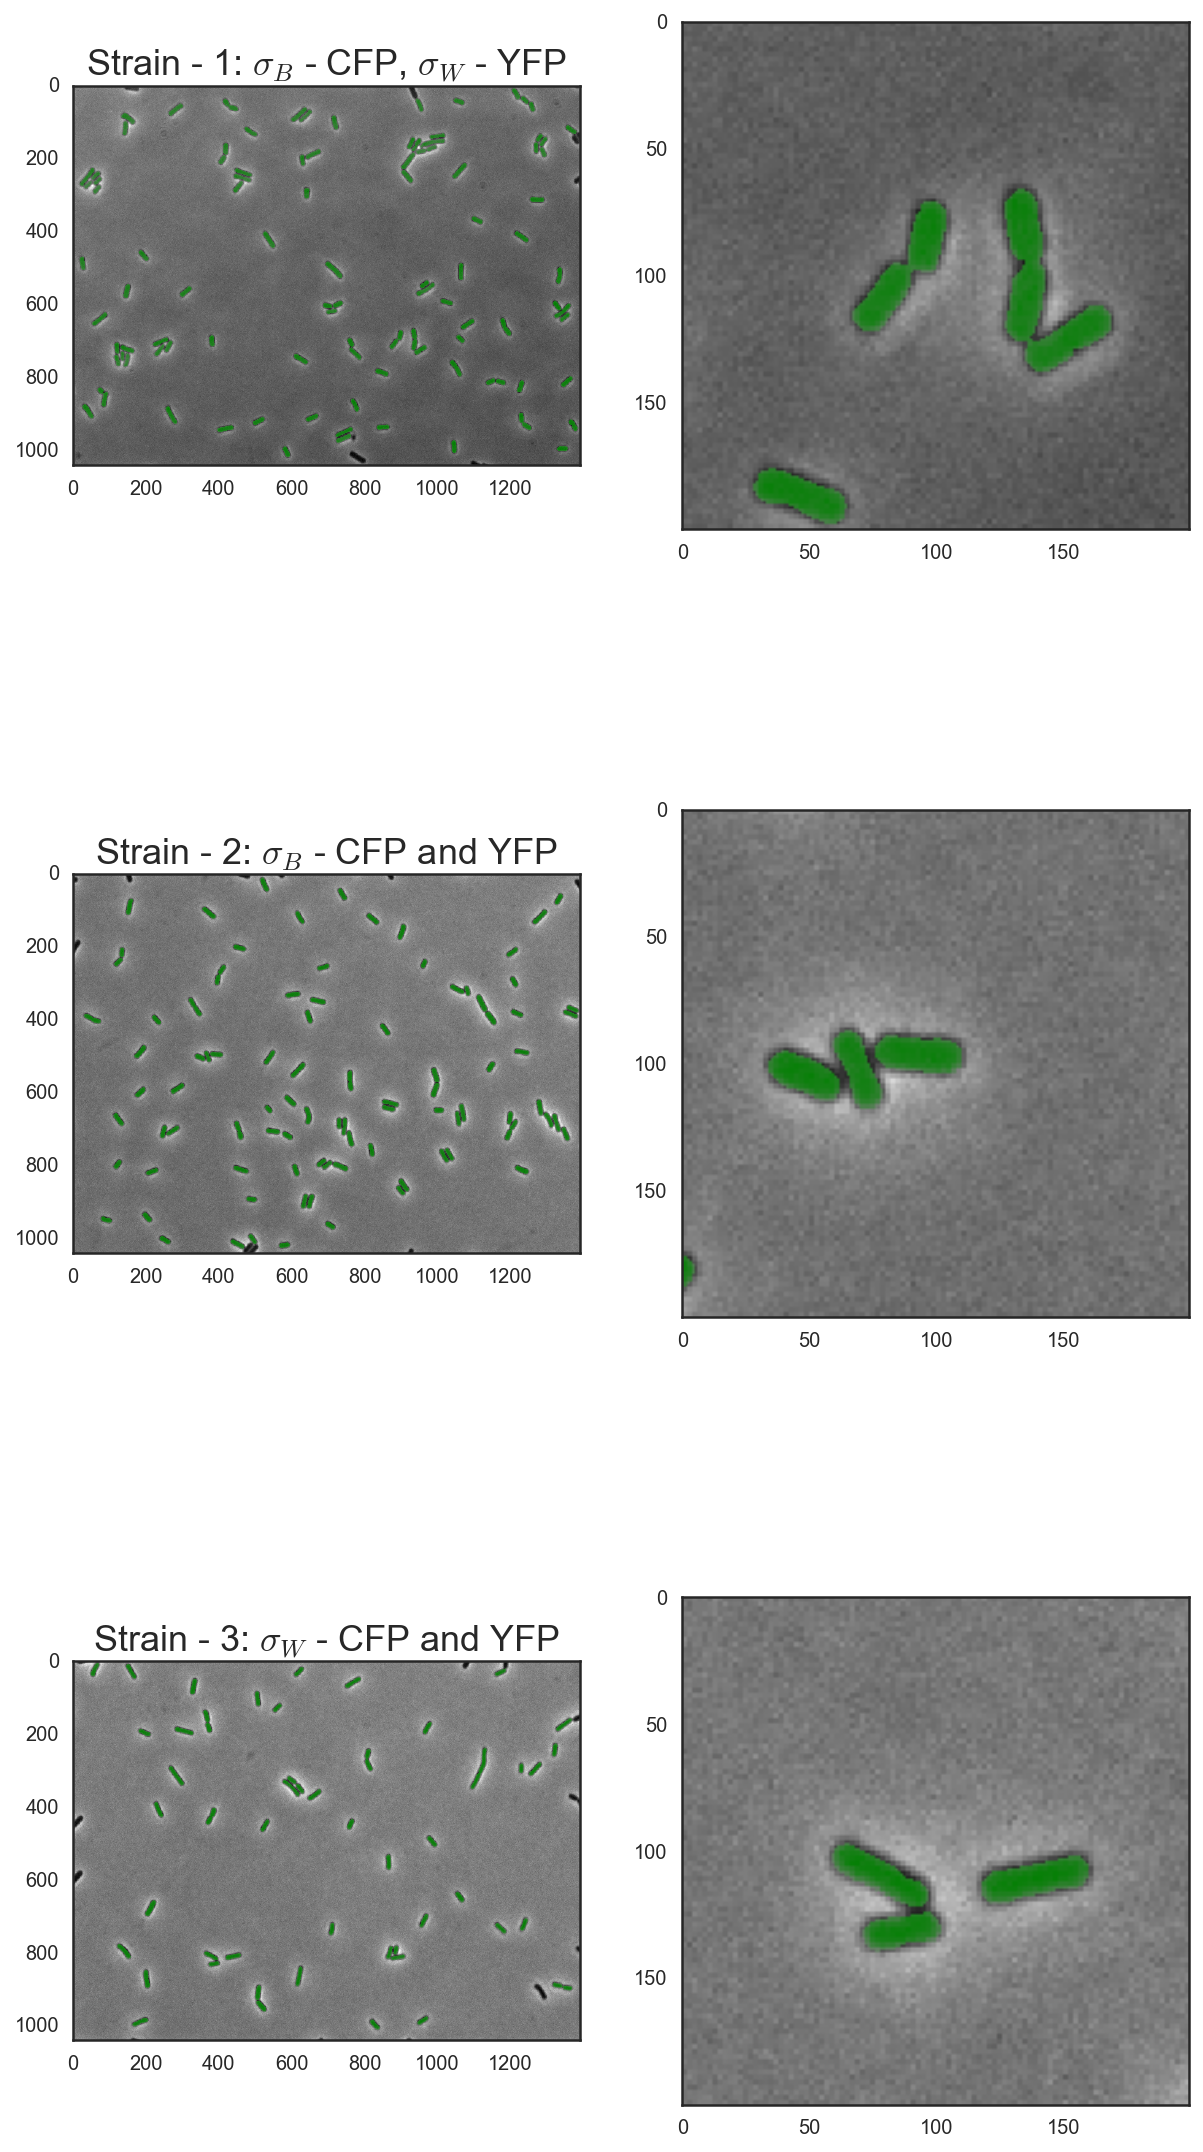

In [186]:
with sns.axes_style('white'):

    plt.figure(figsize=(10,20))
    plt.subplot(3,2,1)
    plt.imshow(im_p_rgb_1)
    plt.title("Strain - 1: $\sigma_B$ - CFP, $\sigma_W$ - YFP")

    plt.subplot(3,2,2)
    plt.imshow(im_p_rgb_1[600:800, 800:1000])
    
    plt.subplot(3,2,3)
    plt.imshow(im_p_rgb_2)
    plt.title("Strain - 2: $\sigma_B$ - CFP and YFP")

    plt.subplot(3,2,4)
    plt.imshow(im_p_rgb_2[400:600, 300:500])
    
    plt.subplot(3,2,5)
    plt.imshow(im_p_rgb_3)
    plt.title("Strain - 3: $\sigma_W$ - CFP and YFP")

    plt.subplot(3,2,6)
    plt.imshow(im_p_rgb_3[700:900,300:500])

Now we want to calculate the image properties for all images from the three strains and the 20 different field of views.
We would like to save the output as a `pandas` dataframe. So we create an empty dataframe and will later append the calculated parameters to it.

In [85]:
df = pd.DataFrame()
strain = ["001","002","003"]
field_of_view = ['001', '002', '003', '004', 
                 '005', '006', '007', '008', 
                 '009', '010', '011', '012', 
                 '013', '014', '015', '016', 
                 '017', '018', '019', '020']
out_list = []

Let's find the properties for all images.

In [86]:
for snap in strain:

    for stack in field_of_view:

        im_file = "./park_et_al/snaps"+snap+"-"+stack+"-r.tif"

        physical_size = 0.065

        im = skimage.io.imread(im_file)

        # Make the structuring element 50 pixel radius disk
        selem = skimage.morphology.disk(50)

        # Threshhold based on mean filter
        im_bw, k = bebi103_thresh(im, selem, white_true=True, 
                                  min_size=400)

        im_bw = skimage.segmentation.clear_border(im_bw)

        # Convert image to float
        im_float = (im.astype(float) - im.min()) / (im.max() - im.min())

        # Compute LoG
        im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float, 2.0)

        # 3x3 square structuring element
        selem = skimage.morphology.square(3)

        # Do max filter and min filter
        im_LoG_max = scipy.ndimage.filters.maximum_filter(im_LoG, 
                                                          footprint=selem)
        im_LoG_min = scipy.ndimage.filters.minimum_filter(im_LoG, 
                                                          footprint=selem)

        # Image of zero-crossings
        im_edge = ((im_LoG >= 0) & (im_LoG_min < 0)) \
            | ((im_LoG <= 0) & (im_LoG_max > 0))

        # Find zero-crossings
        im_edge = zero_crossing_filter(im_LoG, 0.001)

        #skeletonize edges
        im_edge = skimage.morphology.skeletonize(im_edge)

        # Fill holes
        im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

        # Remove small objectes that are not bacteria
        im_bw = skimage.morphology.remove_small_objects(im_bw, 
                                                        min_size=100)

        # Clear border with large buffer size b/c LoG procedure came 
        # off border
        im_bw = skimage.segmentation.clear_border(im_bw, buffer_size=5)

        # Label binary image; backward kwarg says value in im_bw 
        # to consider backgr.
        im_labeled, n_labels = skimage.measure.label(
                                im_bw, background=0, return_num=True)

        # Load other images
        image_dir = './park_et_al/'
        im_p_file = image_dir + 'snaps'+snap+"-"+stack+"-p.tif"
        im_c_file = image_dir + 'snaps'+snap+"-"+stack+"-c.tif"
        im_y_file = image_dir + 'snaps'+snap+"-"+stack+"-y.tif"

        # Load images and store in list [phase, RFP, CFP, YFP]
        im_p = skimage.io.imread(im_p_file)
        im_c = skimage.io.imread(im_c_file)
        im_y = skimage.io.imread(im_y_file)

        # Upsample other images (2 means 2x as big, order=0 means no 
        #interpolation)
        im_p = scipy.ndimage.zoom(im_p, 2, order=0)
        im_c = scipy.ndimage.zoom(im_c, 2, order=0)
        im_y = scipy.ndimage.zoom(im_y, 2, order=0)

        # Get properties about the CFP and YFP channels
        im_c_props = skimage.measure.regionprops(im_labeled, 
                                                 intensity_image=im_c)
        im_y_props = skimage.measure.regionprops(im_labeled, 
                                                 intensity_image=im_y)

        list_c_props = [ [int(snap), int(stack), "C" ,prop.label, 
                      prop.area * physical_size**2, 
                     int(prop.mean_intensity)] for prop in im_c_props]
        
        out_list.append(list_c_props)
        #df.append(list_c_props)

        list_y_props = [ [int(snap), int(stack), "Y" ,prop.label, 
                      prop.area * physical_size**2, 
                     int(prop.mean_intensity)] for prop in im_y_props]
        out_list.append(list_y_props)
        #df.append(list_y_props)

#save data in to a dataframe

df=pd.DataFrame()
for lists in out_list:
    df=df.append(lists, ignore_index=True)
df.columns = ["Strain", "Field", "Channel", "Bacterium", "Area", 
              "Intensity"]



Let's take a look as to how the dataset looks like.

In [162]:
df.head()

,Strain,Field,Channel,Bacterium,Area,Intensity
0,1,1,C,1,2.513875,841
1,1,1,C,2,1.499875,541
2,1,1,C,3,2.420925,956
3,1,1,C,4,1.749150,796
4,1,1,C,5,2.327975,576


Let's do some plots. The most obvious ones were discussed in the tutorial, plotting the intensity from $\sigma_B$ and $\sigma_W$ obtained from the CFP and the YFP channel.

We will plot it for the three strains, out of which we hope to deduce something from the first strain, while using the other two graphs as our positive controls. That is because since the same sigma factor is driving the expression of two different fluorescent proteins, we expect to see a linear correlation between the two.

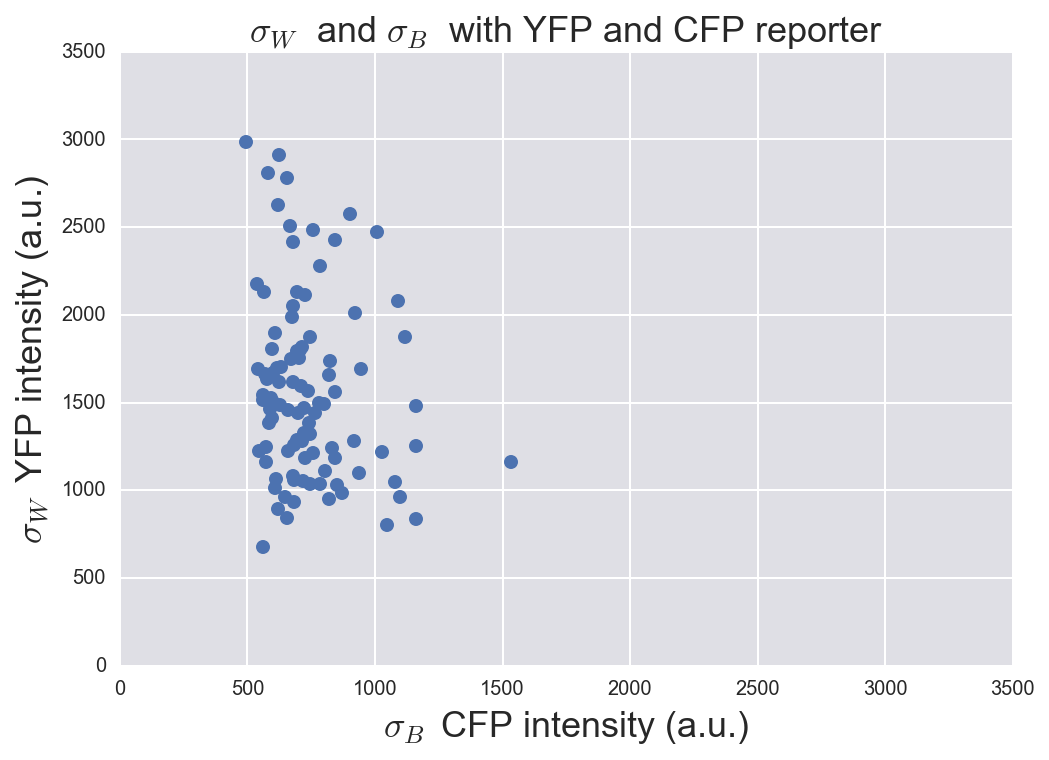

In [180]:
plt.plot(np.array(df
                  [(df["Strain"]==1) 
                   & (df["Field"]==20)&
                   (df["Channel"]=="C")]["Intensity"]), np.array(df
                  [(df["Strain"]==1) 
                   & (df["Field"]==20)&
                   (df["Channel"]=="Y")]["Intensity"]), 'o' )
plt.xlabel("$\sigma_B\,$ CFP intensity (a.u.)")
plt.ylabel("$\sigma_W\,$ YFP intensity (a.u.)")
plt.xlim(0,3500)
plt.ylim(0,3500)
plt.title("$\sigma_W\,\,$ and $\sigma_B\,\,$ with YFP and CFP reporter")

This doesn't look very clean, however, there does seem to be some level of bias towards YFP pixel intensity ($\sigma_W$) as compared to the CFP pixel intensity ($\sigma_B$). It seems like the behaviour of these two sigma factors follows a rather independent relationship [its really hard to say though because of the noise], as the points seem to line up parallel to the Y axis, which suggests that at the same $\sigma_B$ levels, the cells show different levels of expression for $\sigma_W$. Let's look at the positive controls and investigate this further.

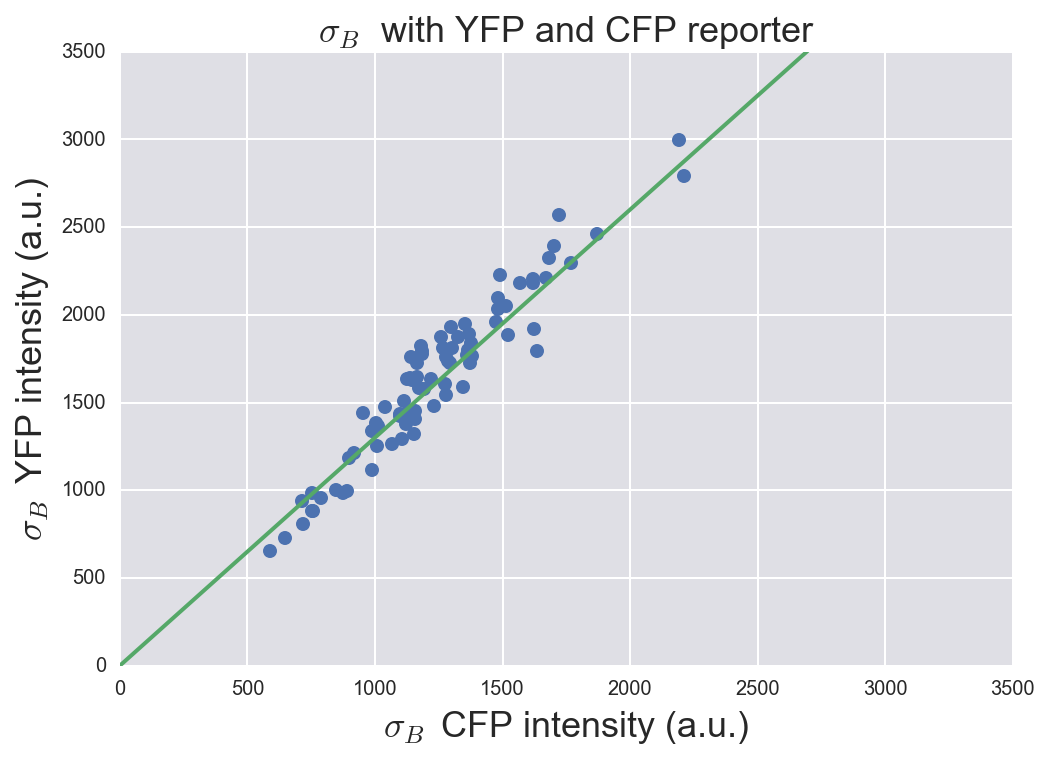

In [211]:
x_p = np.arange(0,3000,1)
y_p = np.arange(0,3000,1)*1.3

plt.plot(np.array(df
                  [(df["Strain"]==2) 
                   & (df["Field"]==20)&
                   (df["Channel"]=="C")]["Intensity"]), np.array(df
                  [(df["Strain"]==2) 
                   & (df["Field"]==20)&
                   (df["Channel"]=="Y")]["Intensity"]), 'o' )
plt.plot(x_p, y_p)
plt.xlabel("$\sigma_B\,$ CFP intensity (a.u.)")
plt.ylabel("$\sigma_B\,$ YFP intensity (a.u.)")
plt.xlim(0,3500)
plt.ylim(0,3500)
plt.title("$\sigma_B\,\,$ with YFP and CFP reporter")

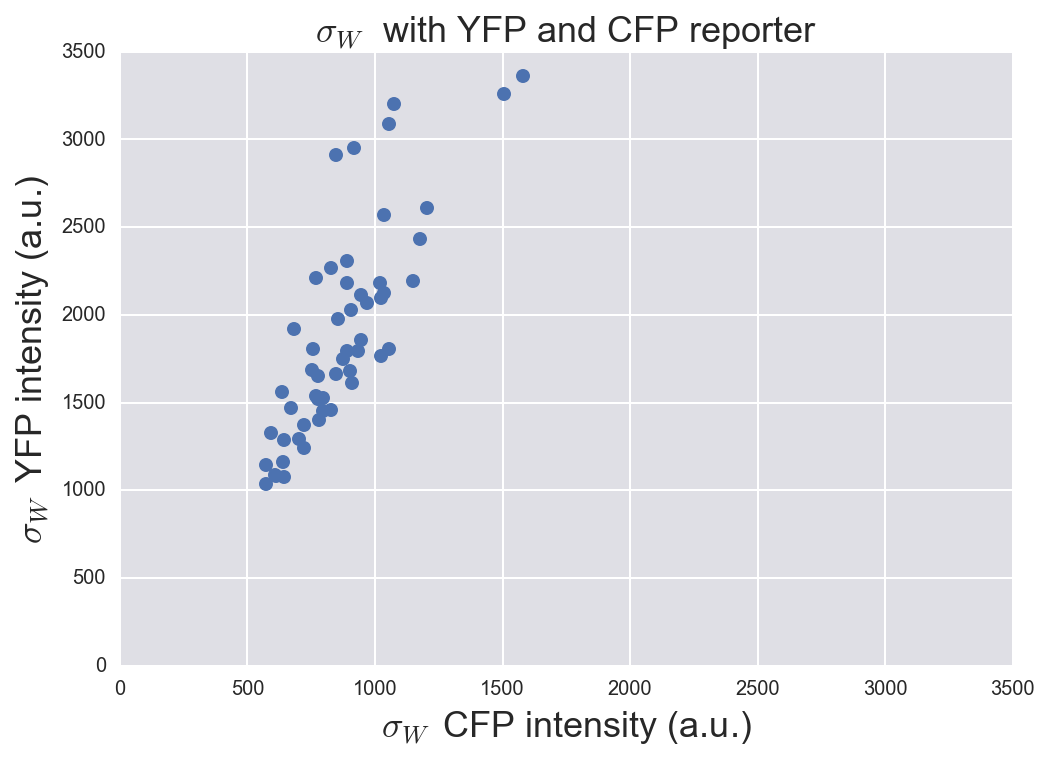

In [181]:
plt.plot(np.array(df
                  [(df["Strain"]==3) 
                   & (df["Field"]==20)&
                   (df["Channel"]=="C")]["Intensity"]), np.array(df
                  [(df["Strain"]==3) 
                   & (df["Field"]==20)&
                   (df["Channel"]=="Y")]["Intensity"]), 'o' )
plt.xlabel("$\sigma_W\,$ CFP intensity (a.u.)")
plt.ylabel("$\sigma_W\,$ YFP intensity (a.u.)")
plt.xlim(0,3500)
plt.ylim(0,3500)
plt.title("$\sigma_W\,\,$ with YFP and CFP reporter")

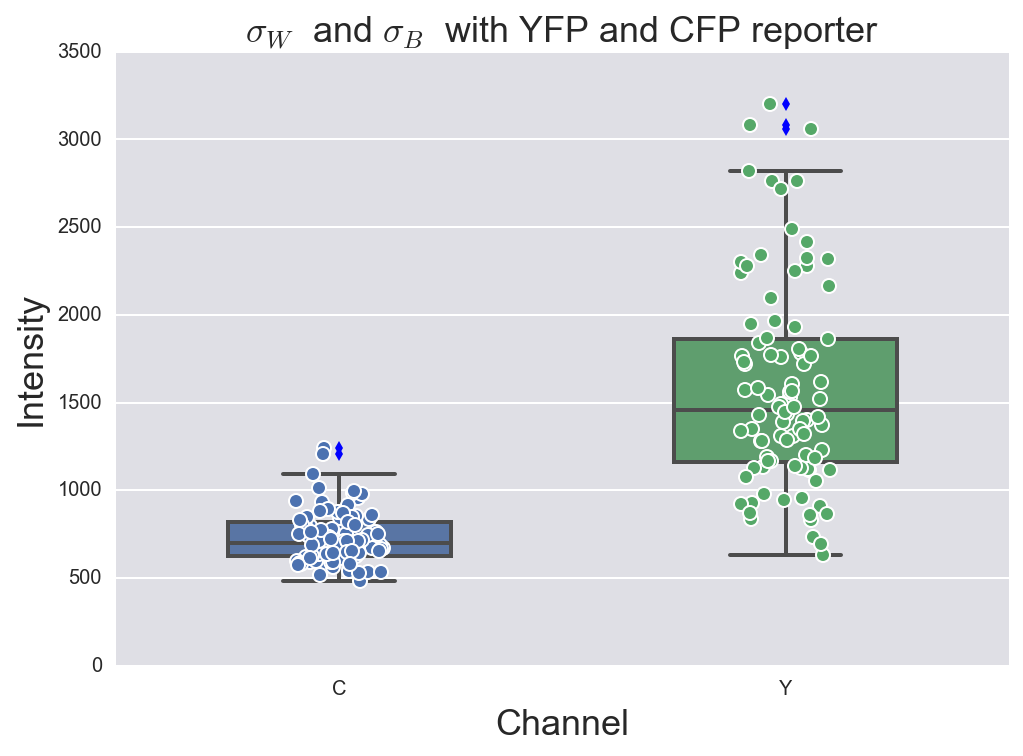

In [213]:
sns.boxplot(x = "Channel", 
            y="Intensity", 
            data = df[(df["Strain"]==1)& (df["Field"]==1)], width=0.5)

sns.stripplot(x = "Channel", 
            y="Intensity", 
            data = df[(df["Strain"]==1)& (df["Field"]==1)], jitter=True)
plt.title("$\sigma_W\,\,$ and $\sigma_B\,\,$ with YFP and CFP reporter")

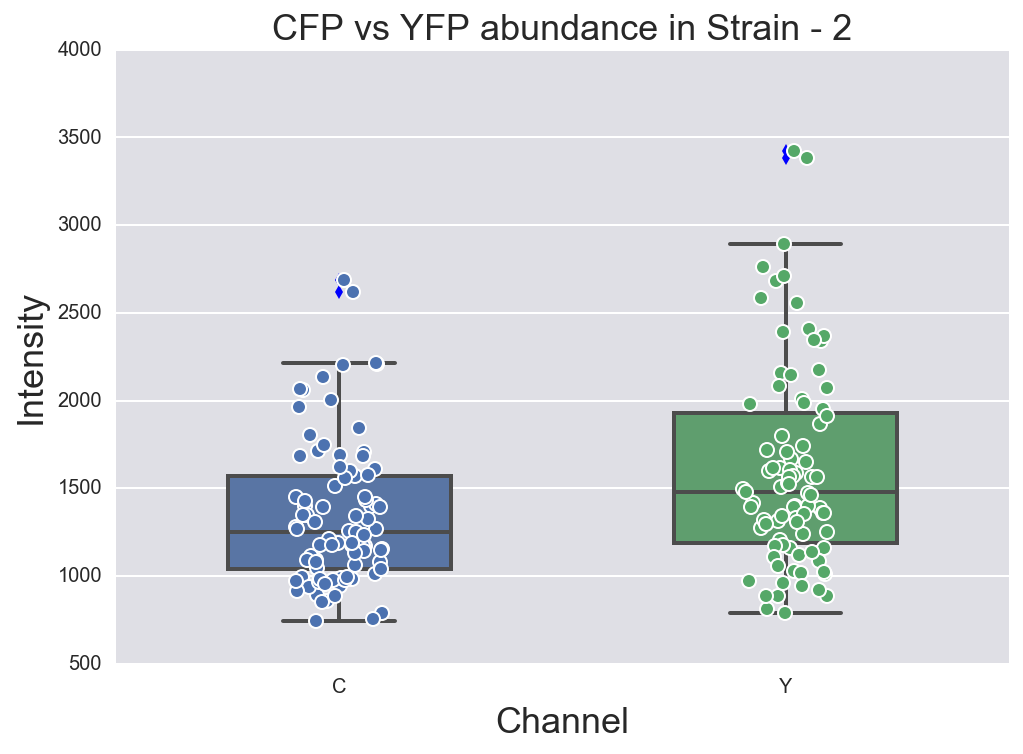

In [214]:
sns.boxplot(x = "Channel", 
            y="Intensity", 
            data = df[(df["Strain"]==2)& (df["Field"]==1)], width=0.5)

sns.stripplot(x = "Channel", 
            y="Intensity", 
            data = df[(df["Strain"]==2)& (df["Field"]==1)], jitter=True)
plt.title("CFP vs YFP abundance in Strain - 2")

The two plots shown above seem to support the observation from the first one, where we plotted the pixel intensities for CFP and YFP expression through $\sigma_W$ and $\sigma_B$ activities. While in the second strain, it seems like CFP and YFP are present in similar proportions, the first plot shows a bias towards YFP expression, which suggests that $\sigma_W$ is more active in those population of cells.
One of the possible explanations is that this makes intuitive sense when you consider the defined role of the two $\sigma$ factors. $\sigma_W$ has been hypothesized to play an important role in regulation of genes involved in transport processes and detoxification, whereas $\sigma_B$ has been hypothesized to regulate genes that are transcribed in the early stationary phase under conditions inimical to sporulation. [source - Uniprot]
Assuming that the culture conditions used in this study were ideal for growth, there was no reason for the cells to turn on the cellular machinery that would have allowed the cell to grow under harsh conditions. However, the cells, while dividing, need genes that drive the transport of single stranded DNA. This could explain why $\sigma_W$ seems more abundant, based on its role in upregulating such genes. Other than that, one can also thing about the transport of essential nutrients and metabolites inside the cell.
However, more follow up experiments would be needed in order to validate this hypothesis.